# Imbalanced datasets
------------------------------------

This example shows how ATOM can help you handle imbalanced datasets. We will evaluate the performance of three different Random Forest models: one trained directly on the imbalanced dataset, one trained on an oversampled dataset and the last one trained on an undersampled dataset.

## Load the data

In [1]:
# Import packages
from atom import ATOMClassifier
from sklearn.datasets import make_classification

In [2]:
# Create a mock imbalanced dataset
X, y = make_classification(
    n_samples=5000,
    n_features=30,
    n_informative=20,
    weights=(0.95,),
    random_state=1,
)

## Run the pipeline

In [3]:
# Initialize atom
atom = ATOMClassifier(X, y, test_size=0.2, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (5000, 31)
Memory: 1.22 MB
Scaled: False
Outlier values: 565 (0.5%)
-------------------------------------
Train set size: 4000
Test set size: 1000
-------------------------------------
|   |      dataset |        train |         test |
| - | ------------ | ------------ | ------------ |
| 0 |  4731 (17.6) |  3785 (17.6) |   946 (17.5) |
| 1 |    269 (1.0) |    215 (1.0) |     54 (1.0) |



In [4]:
# Let's have a look at the data. Note that, since the input wasn't
# a dataframe, atom has given default names to the columns.
atom.head()

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,...,feature 22,feature 23,feature 24,feature 25,feature 26,feature 27,feature 28,feature 29,feature 30,target
0,-3.778228,-0.812052,-0.896615,-3.499848,-1.198172,0.670656,-0.740861,0.723931,0.987058,-1.280431,...,-1.372013,-1.582733,-5.205504,-0.132154,-2.046509,1.171858,-0.937969,-1.000315,-5.039237,0
1,-0.376098,-2.040344,-1.187582,-0.543320,2.283740,-0.199718,1.371512,2.533223,-1.065436,1.181449,...,0.785491,2.542636,-8.172737,-0.014625,-0.476868,1.121809,-4.180679,4.526489,-3.113989,0
2,0.098476,1.255913,0.040136,-7.349154,0.911161,-2.400060,-0.995364,3.451334,3.276193,1.191030,...,3.323461,-0.211275,-0.646718,-0.804356,3.738427,0.608230,-0.404319,1.287946,0.236896,0
3,-2.733745,-2.329786,0.883725,9.381290,1.975243,-2.876693,0.169162,-2.638822,0.432828,-1.093796,...,0.044253,-1.316711,4.813267,0.087488,3.813586,-1.438706,-0.044852,3.106058,-4.622981,0
4,-1.194097,2.582772,0.964323,10.242885,0.636551,-1.848875,-0.981837,0.903811,0.747750,1.526570,...,-3.227021,1.712595,-7.194171,-0.309420,-8.076342,0.742821,-0.876746,5.963986,-1.404056,0


In [5]:
# Let's start reducing the number of features
atom.feature_selection("RFE", solver="RF", n_features=12)

Fitting FeatureSelector...
Performing feature selection ...
 --> RFE selected 12 features from the dataset.
   >>> Dropping feature feature 2 (rank 12).
   >>> Dropping feature feature 3 (rank 8).
   >>> Dropping feature feature 5 (rank 2).
   >>> Dropping feature feature 7 (rank 17).
   >>> Dropping feature feature 8 (rank 14).
   >>> Dropping feature feature 11 (rank 19).
   >>> Dropping feature feature 12 (rank 3).
   >>> Dropping feature feature 13 (rank 11).
   >>> Dropping feature feature 14 (rank 9).
   >>> Dropping feature feature 15 (rank 13).
   >>> Dropping feature feature 17 (rank 5).
   >>> Dropping feature feature 19 (rank 16).
   >>> Dropping feature feature 20 (rank 4).
   >>> Dropping feature feature 23 (rank 7).
   >>> Dropping feature feature 24 (rank 10).
   >>> Dropping feature feature 25 (rank 18).
   >>> Dropping feature feature 26 (rank 6).
   >>> Dropping feature feature 27 (rank 15).


In [6]:
# Fit a model directly on the imbalanced data
atom.run("RF", metric="ba")


Training ========================= >>
Models: RF
Metric: balanced_accuracy


Results for Random Forest:
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 1.0
Test evaluation --> balanced_accuracy: 0.6111
Time elapsed: 0.893s
-------------------------------------------------
Total time: 0.893s


Final results ==================== >>
Duration: 0.894s
-------------------------------------
Random Forest --> balanced_accuracy: 0.6111 ~


In [7]:
# The transformer and the models have been added to the branch
atom.branch

Branch: master
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: RF_class
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
 --> Models: RF

## Oversampling

In [8]:
# Create a new branch for oversampling
atom.branch = "oversample"

New branch oversample successfully created.


In [9]:
# Perform oversampling of the minority class
atom.balance(strategy="smote")

Oversampling with SMOTE...
 --> Adding 3570 samples to class 1.


In [10]:
atom.classes  # Check the balanced training set!

,dataset,train,test
0,4731,3785,946
1,3839,3785,54


In [11]:
# Train another model on the new branch. Add a tag after 
# the model's acronym to distinguish it from the first model
atom.run("rf_os")  # os for oversample


Training ========================= >>
Models: RF_os
Metric: balanced_accuracy


Results for Random Forest:
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 1.0
Test evaluation --> balanced_accuracy: 0.7214
Time elapsed: 1.424s
-------------------------------------------------
Total time: 1.424s


Final results ==================== >>
Duration: 1.424s
-------------------------------------
Random Forest --> balanced_accuracy: 0.7214 ~


## Undersampling

In [12]:
# Create the undersampling branch
# Split from master to not adopt the oversmapling transformer
atom.branch = "undersample_from_master"

New branch undersample successfully created.


In [13]:
atom.classes  # In this branch, the data is still imbalanced

,dataset,train,test
0,4731,3785,946
1,269,215,54


In [14]:
# Perform undersampling of the majority class
atom.balance(strategy="NearMiss")

Undersampling with NearMiss...
 --> Removing 3570 samples from class 0.


In [15]:
atom.run("rf_us")


Training ========================= >>
Models: RF_us
Metric: balanced_accuracy


Results for Random Forest:
Fit ---------------------------------------------
Train evaluation --> balanced_accuracy: 1.0
Test evaluation --> balanced_accuracy: 0.7225
Time elapsed: 0.150s
-------------------------------------------------
Total time: 0.150s


Final results ==================== >>
Duration: 0.150s
-------------------------------------
Random Forest --> balanced_accuracy: 0.7225 ~


In [16]:
# Check that the branch only contains the desired transformers 
atom.branch

Branch: undersample
 --> Pipeline: 
   >>> FeatureSelector
     --> strategy: RFE
     --> solver: RF_class
     --> n_features: 12
     --> max_frac_repeated: 1.0
     --> max_correlation: 1.0
     --> kwargs: {}
   >>> Balancer
     --> strategy: NearMiss
     --> kwargs: {}
 --> Models: RF_us

## Analyze results

In [17]:
atom.evaluate()

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,accuracy,average_precision,balanced_accuracy,f1,jaccard,matthews_corrcoef,precision,recall,roc_auc
RF,0.958,0.711949,0.611111,0.363636,0.222222,0.461276,1.000000,0.222222,0.944405
RF_os,0.952,0.585779,0.721439,0.510204,0.342466,0.488058,0.568182,0.462963,0.940431
RF_us,0.508,0.471905,0.722496,0.174497,0.095588,0.201866,0.095941,0.962963,0.870762


In [18]:
atom.plot_prc()

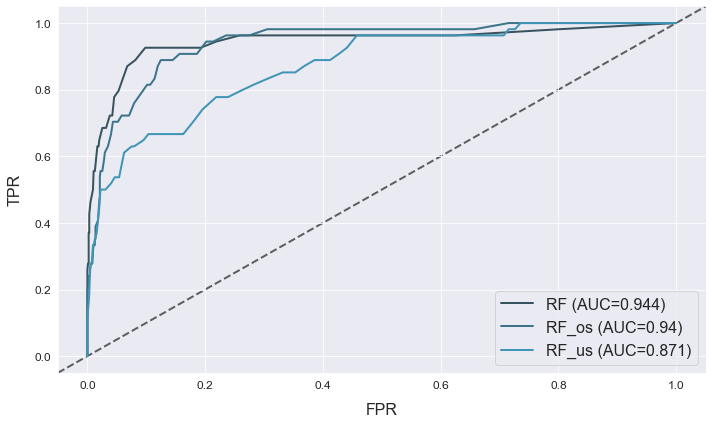

In [19]:
atom.plot_roc()